# DL PROJECT

In [1]:
pip install torch torchvision torchaudio


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\Bine\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip



  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/22/fa/23a6456de8b6fbac7026efb9c7163335c57b79437618686149daf2f9be39/torchaudio-2.3.1-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
    --------------------------------------- 0.0/2.4 MB 262.6 kB/s eta 0:00:09
    --------------------------------------- 0.0/2.4 MB 326.8 kB/s eta 0:00:08
   -- ------------------------------------- 0.1/2.4 MB 722.1 kB/s eta 0:00:04
   ----- ---------------------------------- 0.3/2.4 MB 1.8 MB/s eta 0:00:02
   -------------- ------------------------- 0.9/2.4 MB 3.9 MB/s eta 0:00:01
   ------------------------------------ --- 2.2/2.4 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 7.9 MB/s eta 0:00:00


In [1]:
# all imports
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim import Adam
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import copy

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


## Mount the drive and unzip images folder

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

In [16]:
#!unzip -q /content/drive/MyDrive/DL_project/data/train_images.zip

Check if access to images is working

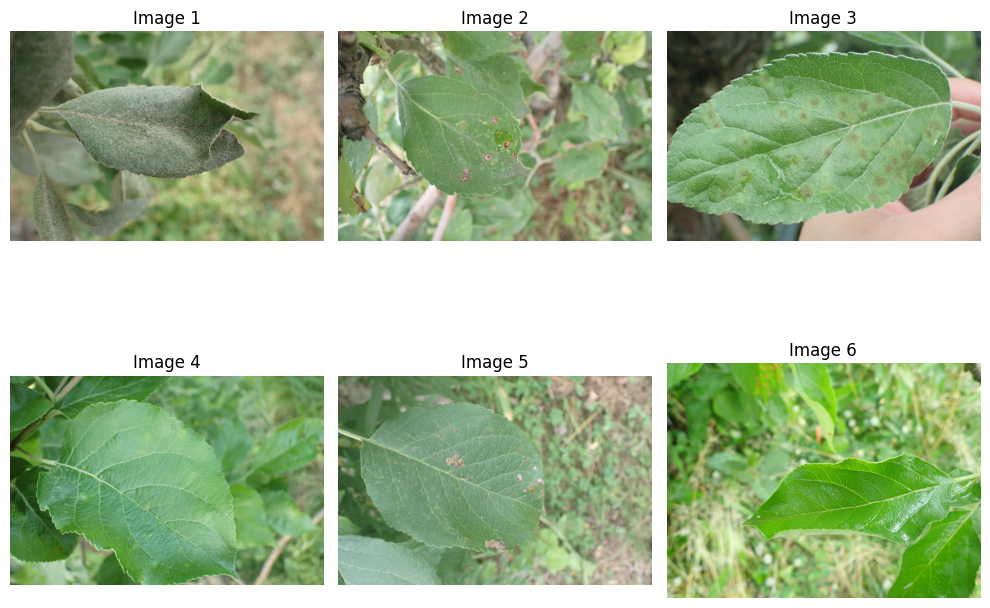

In [3]:
# List files in the directory
img_dir = './data/21/train_images/'

# List the image files
image_files = os.listdir(img_dir)

# Display a 3x2 grid of images
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        # Load an image
        image_path = os.path.join(img_dir, image_files[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image
        ax.imshow(image)
        ax.axis('off')  # Hide the axis
        ax.set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

In [4]:
train_csv_path = "./data/21/train.csv"
train_df = pd.read_csv(train_csv_path)

print(train_df.shape)

train_df.head()

(18632, 2)


image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex

## Data preparation
- data loader
- data augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images shape: torch.Size([32, 3, 224, 224])
Labels: tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])


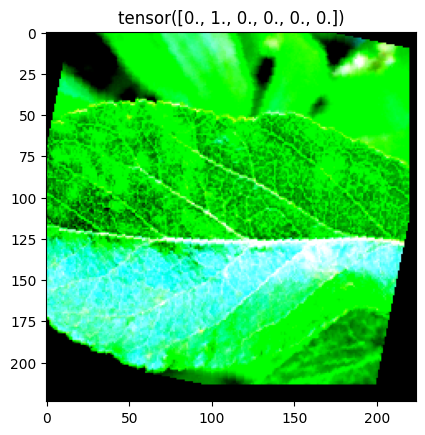

In [5]:
from torchvision.transforms import InterpolationMode


# dataset class
class TrainDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = self.dataframe.iloc[index, 0]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        labels = self.dataframe.iloc[index, 1]

        if self.transform:
            img = self.transform(img)

        return img, labels


# transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# resnet50 transforms
train_transform_resnet = transforms.Compose([
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_resnet = transforms.Compose([
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# VIT transforms
train_transform_vit = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_vit = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# effiecientnet transforms
train_transform_eff = transforms.Compose([
    transforms.Resize(320, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_eff = transforms.Compose([
    transforms.Resize(320, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




# handle multiple classifications
mlb = MultiLabelBinarizer(classes=['healthy', 'scab', 'frog_eye_leaf_spot', 'complex', 'rust', 'powdery_mildew'])

# get labels
train_df = pd.read_csv("./data/21/train.csv")
train_df['labels'] = train_df['labels'].str.split()
train_labels = mlb.fit_transform(train_df['labels'])
#print(train_df.head)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    labels = [list(set(label)) for label in labels]  # no duplicates
    labels = torch.tensor(mlb.transform(labels), dtype=torch.float32)
    return images, labels

# init dataset and dataloader
img_dir = "./data/21/train_images/"

# resnet50
train_dataset_res = TrainDataset(dataframe=train_df, img_dir=img_dir, transform=train_transform_resnet)
train_loader_res = DataLoader(train_dataset_res, batch_size=32, shuffle=True, collate_fn=collate_fn)

# VIT transformer
train_dataset_vit = TrainDataset(dataframe=train_df, img_dir=img_dir, transform=train_transform_vit)
train_loader_vit = DataLoader(train_dataset_vit, batch_size=32, shuffle=True, collate_fn=collate_fn)

# check if dataloader works correctly
images, labels = next(iter(train_loader_res))
print("Images shape:", images.shape)
print("Labels:", labels[:5])

# print 1st image and label
img = images[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(labels[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['healthy']
['healthy']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['scab']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['rust']
['healthy']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['rust']
['frog_eye_leaf_spot']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['powdery_mildew']


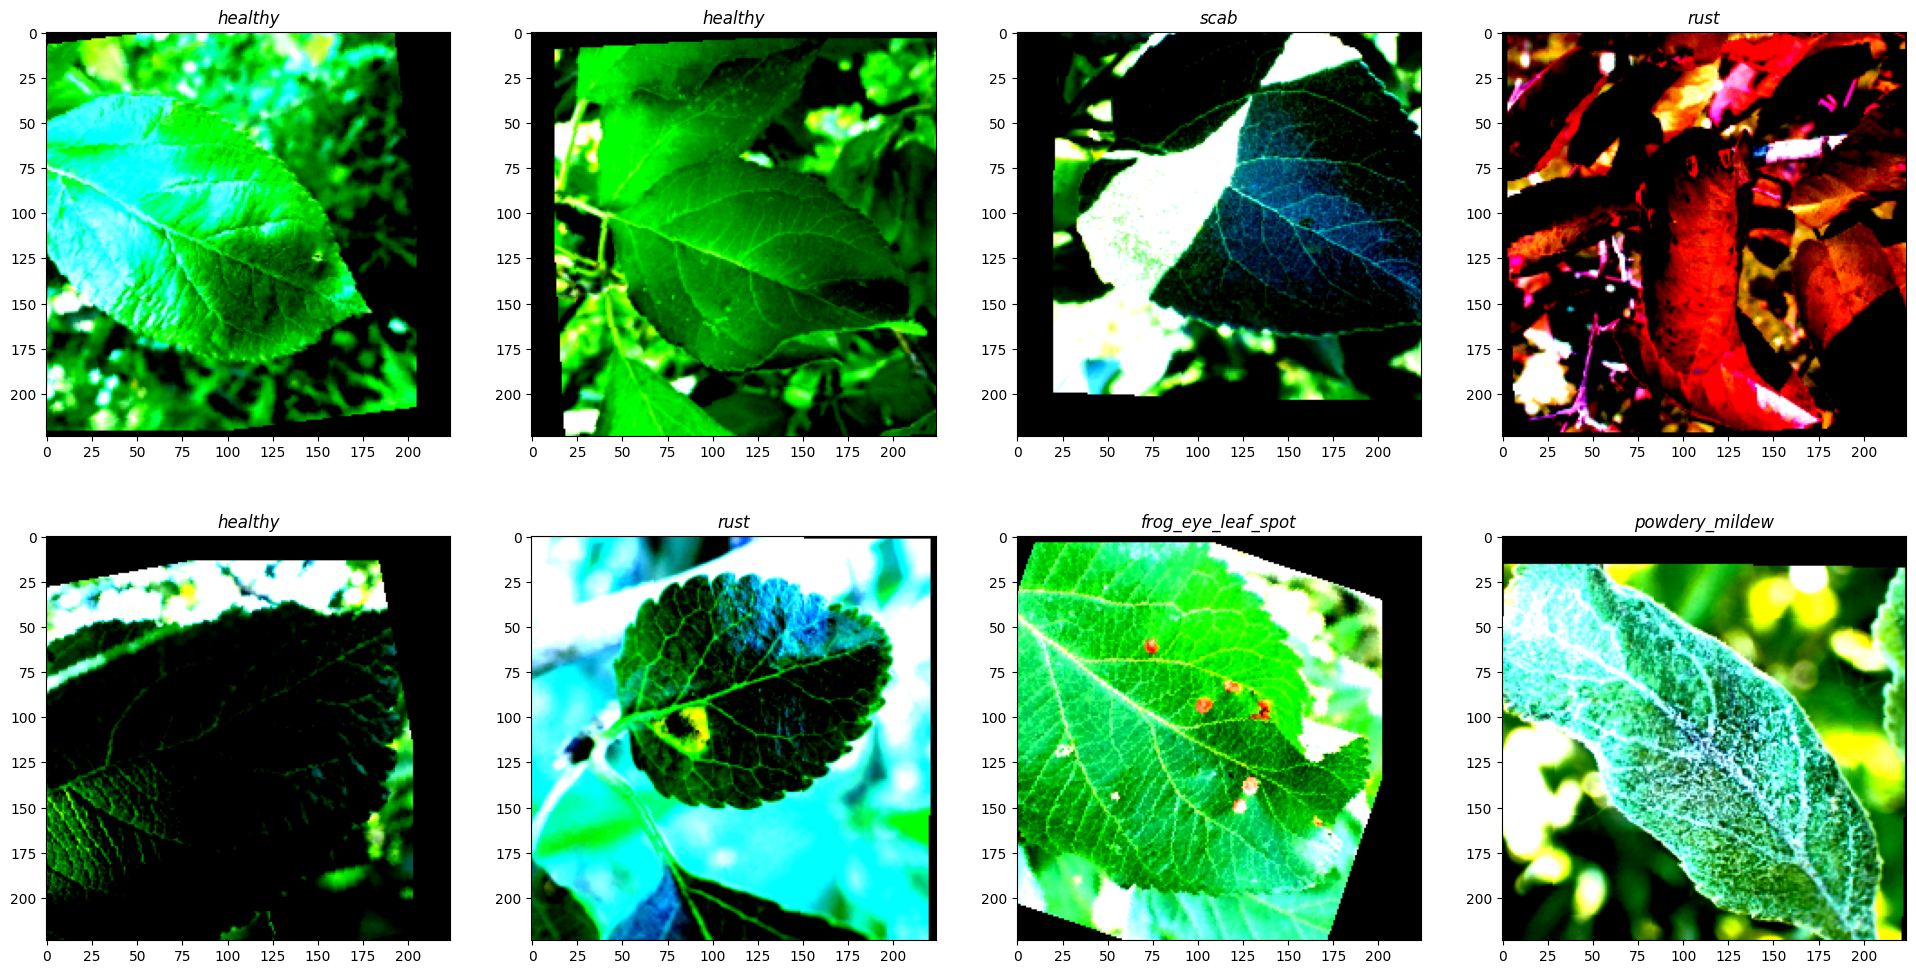

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


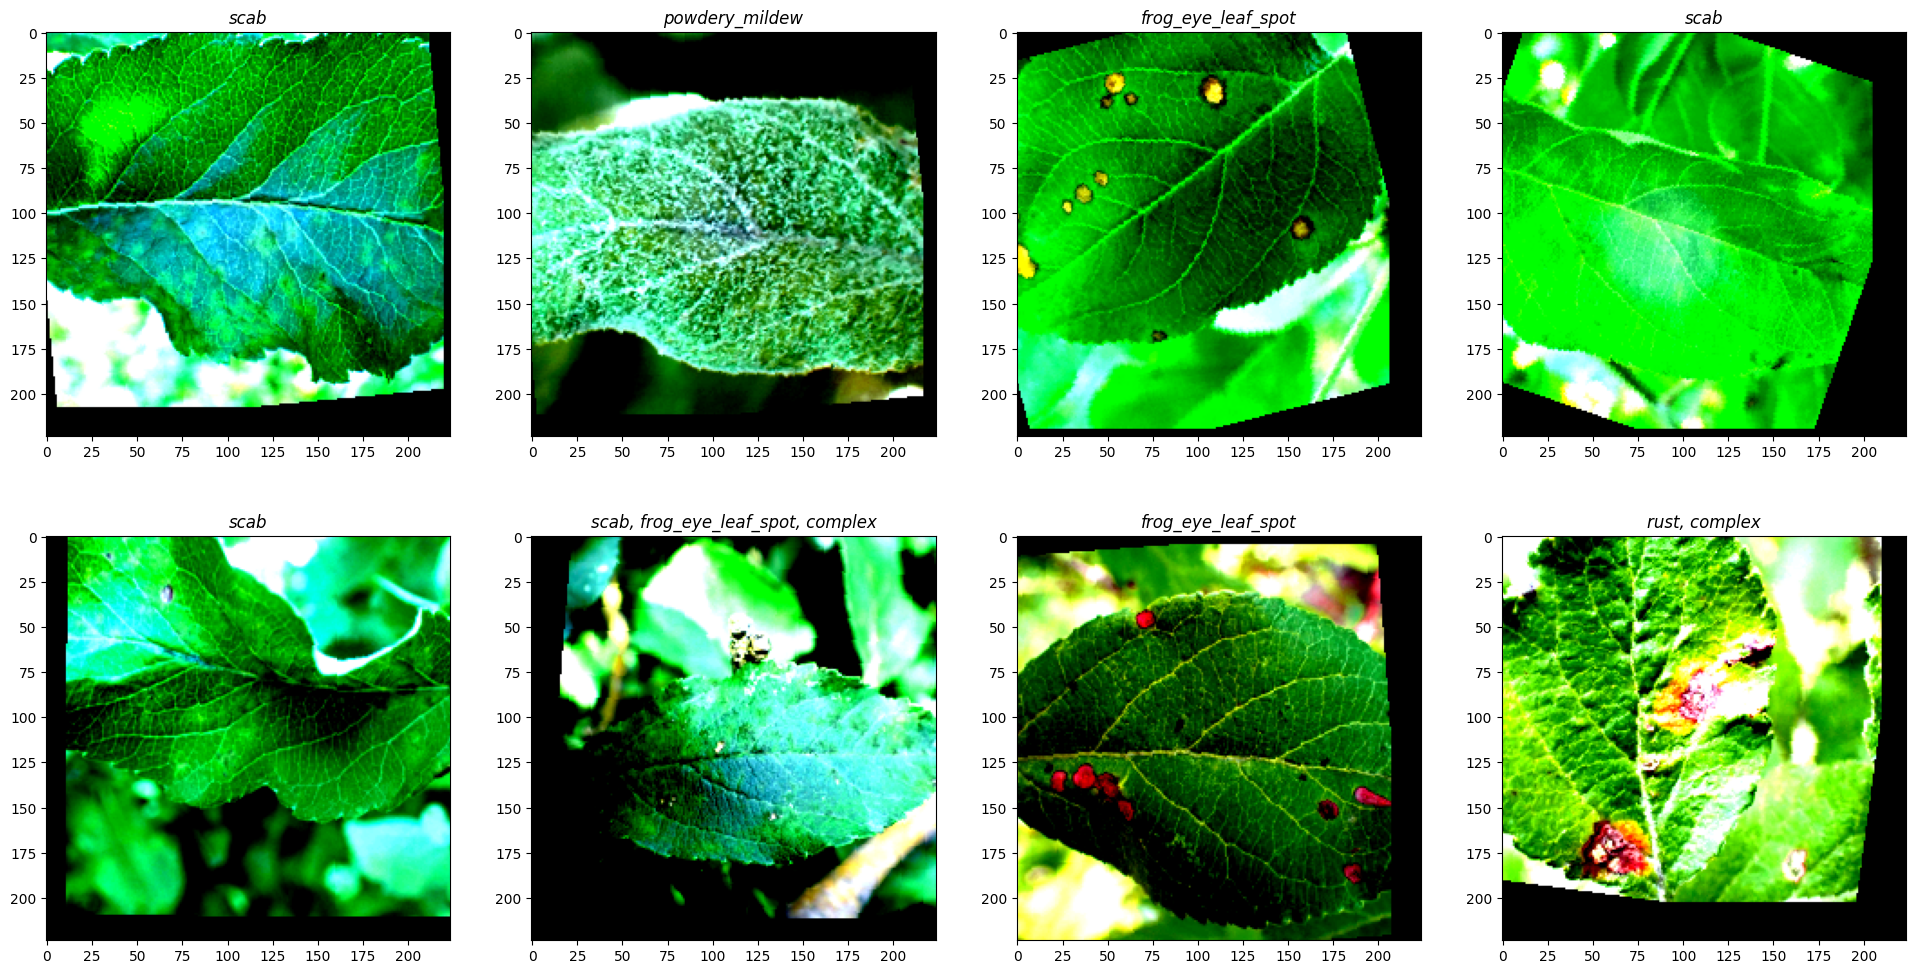

In [6]:
# Displaying random trainset images

fig=plt.figure(figsize=(24, 12))
columns = 4
rows = 2

# resnet
for i in range(columns * rows):
    input, label = train_dataset_res[np.random.randint(len(train_dataset_res))]
    print(label)
    img = input.detach().numpy().transpose((1, 2, 0))

    ax = fig.add_subplot(rows, columns, i + 1)
    label_names = str(label).replace("'", "").replace("[", "").replace("]", "")
    ax.set_title(label_names, fontstyle='italic')
    plt.imshow(img)

plt.show()

# VIT
fig=plt.figure(figsize=(24, 12))
columns = 4
rows = 2

for i in range(columns * rows):
    input, label = train_dataset_vit[np.random.randint(len(train_dataset_vit))]
    img = input.detach().numpy().transpose((1, 2, 0))

    ax = fig.add_subplot(rows, columns, i + 1)
    label_names = str(label).replace("'", "").replace("[", "").replace("]", "")
    ax.set_title(label_names, fontstyle='italic')
    plt.imshow(img)
    
plt.show()

## Analyze the data distribution in the dataset

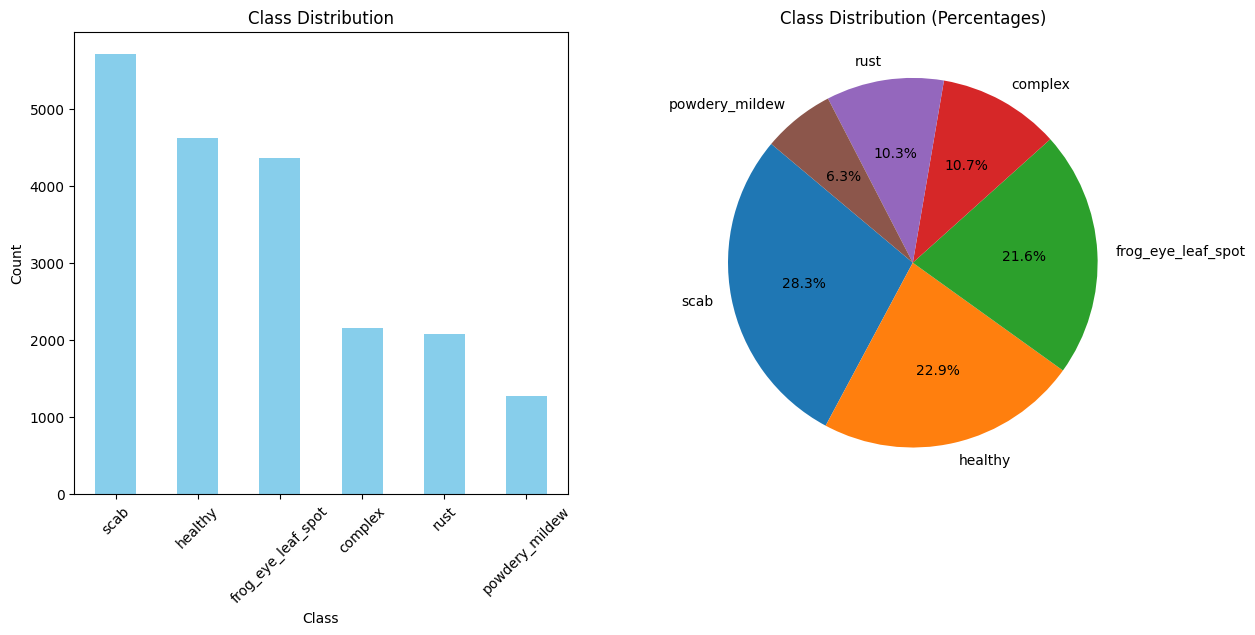

In [7]:
# Extract labels from the dataset
labels = train_df['labels'].explode()
class_counts = labels.value_counts()

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
#plt.show()

plt.subplot(1, 2, 2)
class_percentages = (class_counts / len(labels)) * 100
class_percentages.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Class Distribution (Percentages)')
plt.ylabel('')

plt.show()

## Train the Network

Define the model, loss function and optimizer

In [8]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

# model
def get_resnet50_model():
  model = models.resnet50(weights="IMAGENET1K_V2")
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, len(mlb.classes_))
  return model

def get_efficientnet_model():
  model = models.efficientnet_b3(weights="IMAGENET1K_V1")
  num_ftrs = model.classifier[1].in_features
  model.classifier[1] = nn.Linear(num_ftrs, len(mlb.classes_))
  return model

model = get_resnet50_model()

# loss, optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

print(model)

Device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1)

Training function, Validation function

In [9]:
# train
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    tmp_loss = 0.0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        tmp_loss += loss.item() * images.size(0)

    epoch_loss = tmp_loss / len(dataloader.dataset)
    return epoch_loss



# validation
def validate_model(model, dataloader, criterion, device):
    model.eval()
    tmp_loss = 0.0

    outputs_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            tmp_loss += loss.item() * images.size(0)
            outputs_list.append(outputs)
            labels_list.append(labels)

    epoch_loss = tmp_loss / len(dataloader.dataset)
    return epoch_loss, outputs_list, labels_list

Cross validation to train the model

In [14]:
kf = KFold(n_splits=5)
fold_results = []

best_model_weights = None
best_model_loss = np.inf

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f'Fold {fold+1}')

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset_res, batch_size=32, sampler=train_subsampler, collate_fn=collate_fn)
    val_loader = DataLoader(train_dataset_res, batch_size=32, sampler=val_subsampler, collate_fn=collate_fn)

    model = get_resnet50_model()
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-4)

    best_val_loss = np.inf
    best_fold_model = None
    for epoch in range(10):  # Train for 10 epochs, adjust as needed
        print(f'Epoch {epoch+1}')
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_outputs, val_labels = validate_model(model, val_loader, criterion, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_fold_model = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    fold_results.append(best_val_loss)

    if best_val_loss < best_model_loss:
        best_model_loss = best_val_loss
        best_model_weights = best_fold_model

print(f'Cross-Validation Loss: {np.mean(fold_results):.4f}')

Fold 1
Epoch 1


IndexError: index 16633 is out of bounds for axis 0 with size 14905

Save the final best model

In [ ]:
torch.save(best_model_weights, 'best_model_res.pth')

## Final model training on the whole train dataset, evaluating every epoch on the validation dataset

Split the dataset into train and validation

In [10]:
# Split the dataset into train and validation
train_df = pd.read_csv("./data/21/train.csv")
train_df['labels'] = train_df['labels'].str.split()
train_labels = mlb.fit_transform(train_df['labels'])

#train_df['labels'] = train_df['labels'].apply(lambda x: ' '.join(x))

train_df = train_df.sample(frac=1).reset_index(drop=True)

train_size = int(0.8 * len(train_df))
val_size = len(train_df) - train_size

# resnet50
train_dataset_res = TrainDataset(dataframe=train_df[:train_size], img_dir=img_dir, transform=train_transform_resnet)
val_dataset_res = TrainDataset(dataframe=train_df[train_size:], img_dir=img_dir, transform=val_transform_resnet)

train_loader_res = DataLoader(train_dataset_res, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader_res = DataLoader(val_dataset_res, batch_size=32, shuffle=False, collate_fn=collate_fn)

# vision transformer
train_dataset_vit = TrainDataset(dataframe=train_df[:train_size], img_dir=img_dir, transform=train_transform_vit)
val_dataset_vit = TrainDataset(dataframe=train_df[train_size:], img_dir=img_dir, transform=val_transform_vit)

train_loader_vit = DataLoader(train_dataset_vit, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader_vit = DataLoader(val_dataset_vit, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f'Train size: {train_size}, Validation size: {val_size}')

Train size: 14905, Validation size: 3727


In [31]:
# Print out all labels from the ResNet dataloader
print("ResNet Labels:")
for _, labels_res in train_loader_res:
    print(labels_res)

ResNet Labels:
tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],

KeyboardInterrupt: 

Train the model

In [ ]:
model = get_resnet50_model()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

best_model_weights = None
best_model_loss = np.inf

for epoch in range(10):
    print(f'Epoch {epoch+1}')
    train_loss = train_model(model, train_loader_res, criterion, optimizer, device)
    val_loss, _, _ = validate_model(model, val_loader_res, criterion, device)

    if val_loss < best_model_loss:
        best_model_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    
# if final and best model are not the same, save also final model
if best_model_weights != model.state_dict():
    torch.save(model.state_dict(), 'final_final_model_res.pth')
    
# save the best model
torch.save(best_model_weights, 'final_model_res.pth')

Epoch 1


Epoch 1, Train Loss: 0.1832, Val Loss: 0.1084
Epoch 2


Training:   3%|▎         | 16/466 [01:29<41:26,  5.53s/it]

## Now also try using Vision Transformer instead of ResNet50

In [ ]:
import timm

In [ ]:
# model
def get_vit_model():
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, len(mlb.classes_))
    return model

model = get_vit_model()
model.to(device)

# loss, optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

print(model)

In [ ]:
# no k-fold, just train on the whole train dataset and evaluate on the validation dataset

In [ ]:
best_model_weights = None
best_model_loss = np.inf

for epoch in range(10):
    print(f'Epoch {epoch+1}')
    train_loss = train_model(model, train_loader_vit, criterion, optimizer, device)
    val_loss, _, _ = validate_model(model, val_loader_vit, criterion, device)

    if val_loss < best_model_loss:
        best_model_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
# if final and best model are not the same, save also final model
if best_model_weights != model.state_dict():
    torch.save(model.state_dict(), 'final_final_model_vit.pth')
    
# save the best model
torch.save(best_model_weights, 'final_model_vit.pth')

## Final evalueation on the validation set

In [ ]:
# load the both best models
resnet_model = get_resnet50_model()
resnet_model.load_state_dict(torch.load('final_model_res.pth'))
resnet_model.to(device)

vit_model = get_vit_model()
vit_model.load_state_dict(torch.load('final_model_vit.pth'))
vit_model.to(device)

Loss is micro averaged F1 score

This means, we calculate the F1 score for each class and then take the average of all the F1 scores. This is done to handle class imbalance.

FORMULA: 

F1 = 2 * (precision * recall) / (precision + recall)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [ ]:
# validation
def validate_model_f1(model, dataloader, criterion, device):
    model.eval()
    tmp_loss = 0.0

    outputs_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            tmp_loss += loss.item() * images.size(0)
            outputs_list.append(outputs)
            labels_list.append(labels)

    epoch_loss = tmp_loss / len(dataloader.dataset)
    return epoch_loss, outputs_list, labels_list

def f1_score(y_true, y_pred):
    y_pred = torch.sigmoid(y_pred)
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    tp = (y_true * y_pred).sum(dim=0).float()
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).float()
    fp = ((1 - y_true) * y_pred).sum(dim=0).float()
    fn = (y_true * (1 - y_pred)).sum(dim=0).float()

    precision = tp / (tp + fp + 1e-15)
    recall = tp / (tp + fn + 1e-15)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-15)
    return f1.mean().item()

In [ ]:
# evaluate the models
resnet_model.eval()
vit_model.eval()

resnet_val_loss, resnet_val_outputs, resnet_val_labels = validate_model_f1(resnet_model, val_loader_res, criterion, device)
vit_val_loss, vit_val_outputs, vit_val_labels = validate_model_f1(vit_model, val_loader_vit, criterion, device)

resnet_f1 = f1_score(torch.cat(resnet_val_labels, 0), torch.cat(resnet_val_outputs, 0))
vit_f1 = f1_score(torch.cat(vit_val_labels, 0), torch.cat(vit_val_outputs, 0))

print(f'ResNet Validation Loss: {resnet_val_loss:.4f}, F1 Score: {resnet_f1:.4f}')
print(f'ViT Validation Loss: {vit_val_loss:.4f}, F1 Score: {vit_f1:.4f}')

In [ ]:
# Displaying random validation set images

fig=plt.figure(figsize=(24, 12))
columns = 4
rows = 2

for i in range(columns * rows):
    input, label = val_dataset_res[np.random.randint(len(val_dataset_res))]
    img = input.detach().numpy().transpose((1, 2, 0))

    ax = fig.add_subplot(rows, columns, i + 1)
    label = str(label).replace("'", "").replace("[", "").replace("]", "")
    ax.set_title(label, fontstyle='italic')
    plt.imshow(img)
    
plt.show()


In [ ]:
# Displaying random validation set images with predictions

fig=plt.figure(figsize=(24, 12))
columns = 4
rows = 2

for i in range(columns * rows):
    input, label = val_dataset_res[np.random.randint(len(val_dataset_res))]
    img = input.detach().numpy().transpose((1, 2, 0))

    input = input.unsqueeze(0).to(device)
    resnet_output = resnet_model(input)
    vit_output = vit_model(input)

    resnet_output = torch.sigmoid(resnet_output)
    vit_output = torch.sigmoid(vit_output)

    resnet_output[resnet_output >= 0.5] = 1
    resnet_output[resnet_output < 0.5] = 0

    vit_output[vit_output >= 0.5] = 1
    vit_output[vit_output < 0.5] = 0

    resnet_output = resnet_output.cpu().detach().numpy().astype(int).flatten()
    vit_output = vit_output.cpu().detach().numpy().astype(int).flatten()

    ax = fig.add_subplot(rows, columns, i + 1)
    label = str(label).replace("'", "").replace("[", "").replace("]", "")
    ax.set_title(f'Label: {label}\nResNet: {resnet_output}\nViT: {vit_output}', fontstyle='italic')
    plt.imshow(img)
    
plt.show()